In [1]:
import tensorflow as tf
import keras
import numpy as np
import time
import random
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM, GRU, SimpleRNN, Conv2D, MaxPooling2D, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2, l1, l1_l2
from collections import deque

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

import qkeras
from qkeras import *

import hls4ml
import pickle


2022-06-21 10:33:00.041505: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-21 10:33:00.041557: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


name convert optimizers ['fuse_bias_add', 'remove_useless_transpose', 'output_rounding_saturation_mode', 'qkeras_factorize_alpha', 'extract_ternary_threshold', 'fuse_consecutive_batch_normalization'] File: flow.py Line: 23
name optimize optimizers ['eliminate_linear_activation', 'fuse_consecutive_batch_normalization', 'fuse_batch_normalization', 'replace_multidimensional_dense_with_conv'] File: flow.py Line: 23
vivado:merge_batch_norm_quantized_tanh Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:quantize_dense_output Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:batchnormalizationquantizedtanh_config_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:batchnormalizationquantizedtanh_function_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:clone_output Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:clone_function_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:optimize_pointwise_conv Get_Optimizer, optimizer/opti

/atlas/bonnet/hls4ml/hls4ml/hls4ml/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [2]:
from nnlar.datashaper import DataShaper
ds = DataShaper.from_h5("../../data/rdgap_mu140.h5")

x, x_val, x_test, y, y_val, y_test = ds()

shapes (1999995, 5, 1) (1999995, 1)
shapes (899992, 5, 1) (99995, 5, 1) (999998, 5, 1)


In [3]:
boosted_model =  tf.keras.models.load_model('../../pb_file')

boosted_model.summary()


2022-06-21 10:33:08.667313: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-21 10:33:08.667364: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-21 10:33:08.667408: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (marbeauty.in2p3.fr): /proc/driver/nvidia/version does not exist
2022-06-21 10:33:08.667872: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [5]:
# settings of the networks 
output = 1

nbr_batch = 64
nbr_epoch = 200
lr=0.001

time_step = 5
nbr_conv_epoch = 70 #number of epochs for the conversion 

weight_decay=0.00000001
patience_es = 12
patience_es7 = 7
patience_rlr = 3
patience_rlr5 = 5
delta = 0.00000001
regularizer = l2

def version(v): return (v)
versions_range = 4 

def units(j): return (j+8)
units_range = 1

In [6]:
integer = 0

def bit_lenghts(i):
    #To change to create models with different bits parameter by defining the smallest bit lenghts 
    #Example : bits 8 ==> (i+4)*4
    return (i+1)*2

def bit_width(i): return {'bits': (i+1)*2, 'integer': integer, 'symmetric': 0, 'alpha':1}

rest_array = [8,10,12]
rest_units_range =  3
bits_range = 7

In [14]:
# path

#path of the tested models 
def models_path(v) : return f"tests/models/optimized_model.h5" 
def predicts_path(v) : return f"tests/predicts/optimized_model.npy" 

#path of the qconverted models
def qmodels_path0(i, v, k): return f"tests/qmodels/qmodels_conv_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest={rest_array[k]}_v{version(v)}.h5"
def qpredicts_path0(i, v, k): return f"tests/qpredicts/qmodels_conv_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest={rest_array[k]}_v{version(v)}.npy"
def qhist_path(i,v,k): return f"tests/qhist/qmodels_conv_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest={rest_array[k]}_v{version(v)}.pkl"
def qhist_path2(i,v,k): return f"tests/qhist/qmodels_conv_lr={lr}_patiencES={patience_es7}_patienceRLR={patience_rlr5}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest={rest_array[k]}_v{version(v)}.pkl"

def qmodels_path1(i): return f"tests/qmodels/qmodels_conv_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest=10.h5"
def qpredicts_path1(i, v, k): return f"tests/qpredicts_240/qmodels_conv_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest={rest_array[k]}_v{version(v)}.npy"

def qmodels_path2(i): return f"tests/qmodels/qmodels_conv_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest=12.h5"
def qpredicts_path2(i): return f"tests/qpredicts/qmodels_conv_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest=12.npy"


#path of the qtrained models
def qtrained_models_path(j, i): return f"tests/qmodels_test/qtrained/qmodels_units={units(j)}_epoch={nbr_epoch}_batch={nbr_batch}_lr={lr},<{bit_lenghts(i)},{integer}>.h5"
def qtrained_predicts_path(j, i):  return f"tests/qpredicts_test/qtrained/qmodels_units={units(j)}_epoch={nbr_epoch}_batch={nbr_batch}_lr={lr},<{bit_lenghts(i)},{integer}>.npy"

#path of the qref models 
def qrefmodels_path (i) : return f"qmodels_epoch={nbr_conv_epoch}/qmodels<{bit_lenghts(i)},{integer}>.h5"
def qrefpredicts_path (i) : return f"qpredicts_epoch={nbr_conv_epoch}/qpredicts<{bit_lenghts(i)},{integer}>.npy"

In [8]:
def exist(path,modeltopred):
    if (os.path.exists(path)==False):
        np.save(path, modeltopred.predict(x_test))
     
    else : print(f'{path} already exists')
def exist_std(path,modeltopred):
    cut_indices = np.where(y_test > 0.24/16)[0]
    if (os.path.exists(path)==False):
        np.save(path, modeltopred.predict(x_test[cut_indices]))
     
    else : print(f'{path} already exists')

In [8]:
model = tf.keras.models.load_model(models_path(0))      
exist(predicts_path(0), model)
ref = 'tests/ref_predicts.npy'
exist(ref, boosted_model)
std_ref = 'tests/std_ref_predicts.npy'
exist_std(std_ref, boosted_model)

for i in range(bits_range):
    for v in range (versions_range):
        for k in range (rest_units_range):

            qmodel0 = qkeras.utils.load_qmodel(qmodels_path0(i,v,k))        
            exist_std(qpredicts_path1(i,v,k), qmodel0)

"""
    qmodel1 = qkeras.utils.load_qmodel(qmodels_path1(i))        
    exist(qpredicts_path1(i), qmodel1)

    
    qmodel2 = qkeras.utils.load_qmodel(qmodels_path2(i))        
    exist(qpredicts_path2(i), qmodel2)
    qmodel3 = qkeras.utils.load_qmodel(qmodels_path3(i))        
    exist(qpredicts_path3(i), qmodel3)"""
    




tests/predicts/optimized_model.npy already exists
tests/ref_predicts.npy already exists
tests/std_ref_predicts.npy already exists
tests/qpredicts_240/qmodels_conv_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<2,0>_rest=8_v0.npy already exists
tests/qpredicts_240/qmodels_conv_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<2,0>_rest=10_v0.npy already exists
tests/qpredicts_240/qmodels_conv_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<2,0>_rest=12_v0.npy already exists
tests/qpredicts_240/qmodels_conv_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<2,0>_rest=8_v1.npy already exists
tests/qpredicts_240/qmodels_conv_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<2,0>_rest=10_v1.npy already exists
tests/qpredicts_240/qmodels_conv_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<2,0>_rest=12_v1.npy already exists
tests/qpredicts_240/qmodels_conv_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<2,0>_rest=8_v2.npy already exists
tests/qpredicts_240/qmodels_conv_patiencES=12_patience

'\n    qmodel1 = qkeras.utils.load_qmodel(qmodels_path1(i))        \n    exist(qpredicts_path1(i), qmodel1)\n\n    \n    qmodel2 = qkeras.utils.load_qmodel(qmodels_path2(i))        \n    exist(qpredicts_path2(i), qmodel2)\n    qmodel3 = qkeras.utils.load_qmodel(qmodels_path3(i))        \n    exist(qpredicts_path3(i), qmodel3)'

In [9]:
print(qpredicts_path0(2,1,2))

tests/qpredicts/qmodels_conv_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<6,0>_rest=12_v1.npy


In [10]:
y_model=qkeras.utils.load_qmodel(qmodels_path0(2,1,2))
qkeras.utils.model_save_quantized_weights(y_model, "tests/weights/quantizedweights.h5")

y_model.load_weights("tests/weights/quantizedweights.h5")

y_model.save("tests/quantizedmodel.h5")

y_keras2 = np.load(qpredicts_path0(2,1,2))

print(mse(y_test,y_keras2))

... quantizing model
9.943244e-06


In [11]:
y_keras0 = np.loadtxt("../out-c1.txt")
print(y_keras0.shape)
print(mse(y_test,np.load(ref)))
MSETIENNE = mse(y_test[:999992],y_keras0[2:])
print(MSETIENNE)


(999994,)
9.775778e-06
9.776478000410742e-06


In [12]:
import ROOT
from ROOT import TCanvas, TColor, TGaxis, TH1D, TPad, TLegend, TLatex, TH2D, TF1, TLine
from ROOT import kBlack, kBlue, kRed, kGreen, kMagenta
%jsroot on

Welcome to JupyROOT 6.26/02


In [21]:
def get_gap_to_previous(sequence, threshold=0.24):

    gap = np.zeros_like(sequence)
    dist_to_prev = 0

    for i in range(0, len(sequence)):
        dist_to_prev += 1
        gap[i] = dist_to_prev

        if sequence[i] > threshold:
            dist_to_prev = 0
    return gap

In [33]:
gap_for_testset=get_gap_to_previous(ds.hit)[:999998]
print(gap_for_testset.shape)
print(y_test.shape)


(999998,)
(999998, 1)


In [34]:

ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)

# Select events with >240MeV
ECUT = 0.24

inds = np.where((y_test[:,0] ))#> ECUT/16))[0]

# Model predictions in array
model_predictions = np.load(qpredicts_path0(2,1,2))


c = TCanvas("c", "c", 600, 600)
c.cd();
c.SetBottomMargin(0.15)
c.SetTopMargin(0.08)
c.SetLeftMargin(0.15)
c.SetRightMargin(0.15)

h1 = TH2D("histogram1", "histogram2", 100, 0, 100, 200, -1.5 ,1.5)
h1.Sumw2()
denorm=16
prof1 = h1.ProfileX("p1", 1, -1, "s")
prof1.Draw("HIST E3")


for x, y in zip(gap_for_testset[inds], model_predictions[inds]-y_test[inds]):
    h1.Fill(x, y*denorm)

h1.GetYaxis().SetTitleFont(43)
h1.GetXaxis().SetTitleFont(43)
h1.GetYaxis().SetTitleOffset(1.55)

h1.SetStats(0)

h1.GetYaxis().SetTitle("Pred - true phase shift [ps]")#"##splitline{One entry per network}{[normalized to unity]}")#"Normalized to unity")
h1.GetXaxis().SetTitle("True phase shift [ps]")#f"{xtitle} of E^{{T}}_{{pred}} - E^{{T}}_{{true}} [GeV]")
#h1.GetYaxis().SetRangeUser(0,0.45)
#h1.GetXaxis().SetRangeUser(0, 0.5)

#SetLabelSize(0.05)
h1.GetXaxis().SetLabelSize(0.03)
h1.GetYaxis().SetLabelSize(0.03)

h1.GetYaxis().SetTitleOffset(1.8)
h1.GetXaxis().SetTitleOffset(1.5)


h1.GetXaxis().SetTitleSize(24)
h1.GetYaxis().SetTitleSize(24)




h1.Draw("colz")




l = TLatex() 
l.SetTextSize(18)
l.SetTextFont(42)
l.SetTitle("title")
l.SetNDC()
l.SetTextColor(kBlack)
l.DrawLatex(0.5, 0.5, "some text: E^{{T}}_{{true}} > 1 GeV")

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: histogram1 (Potential memory leak).


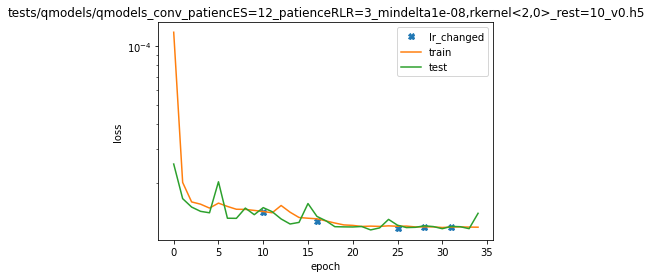

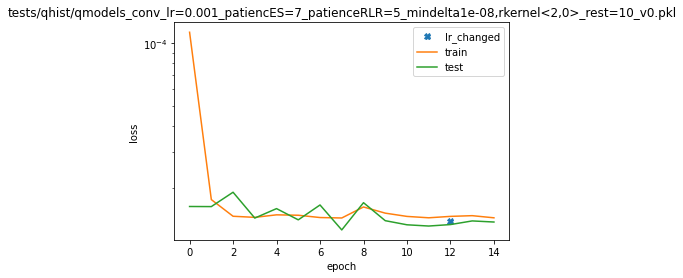

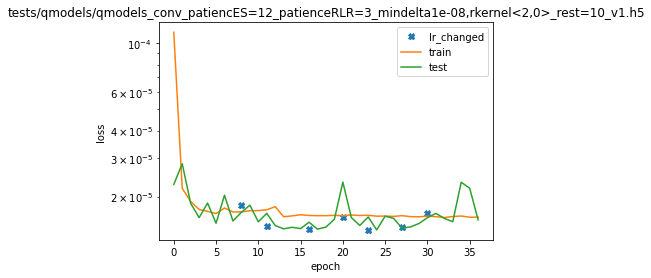

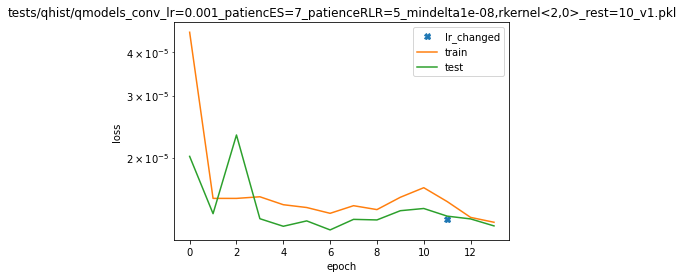

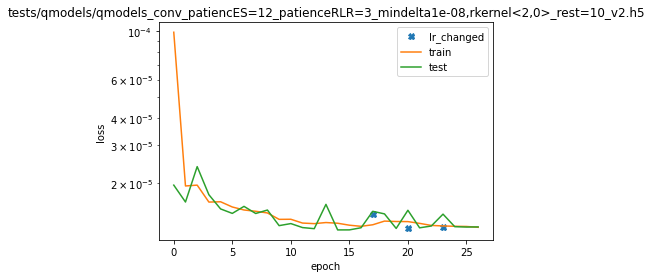

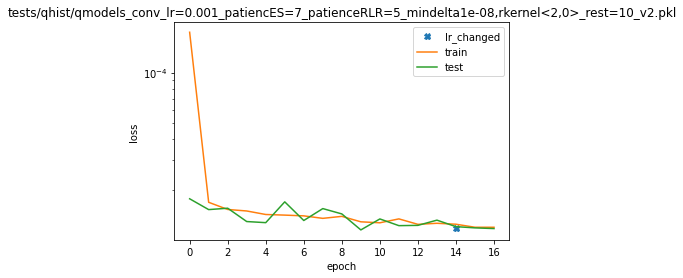

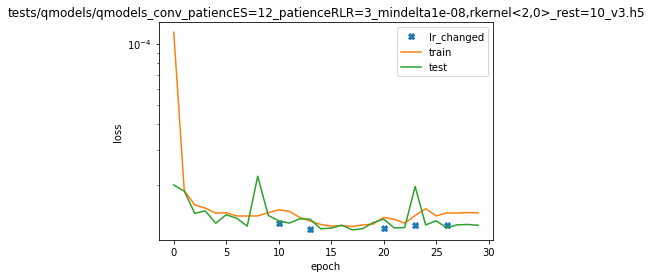

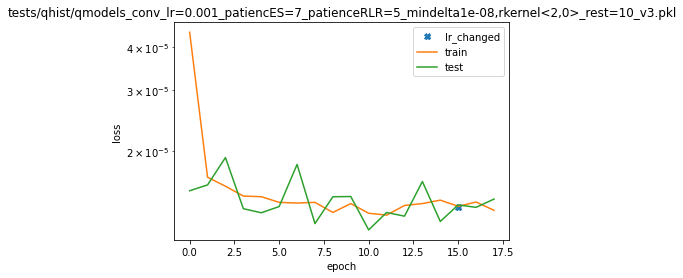

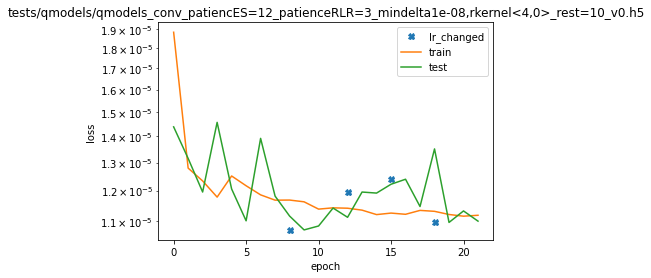

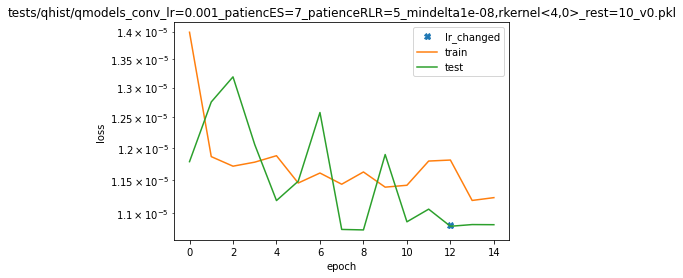

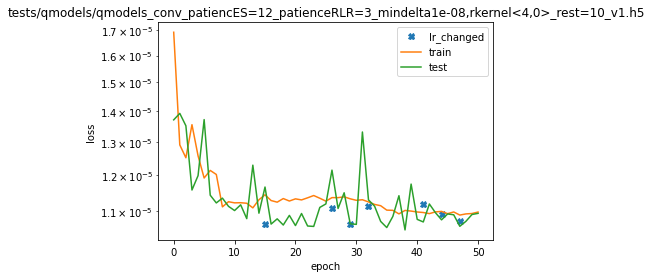

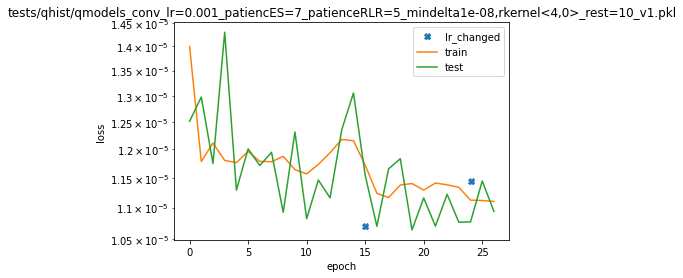

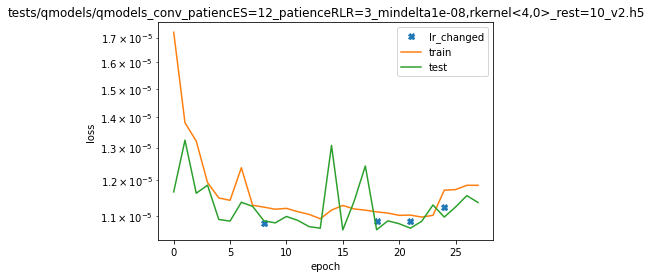

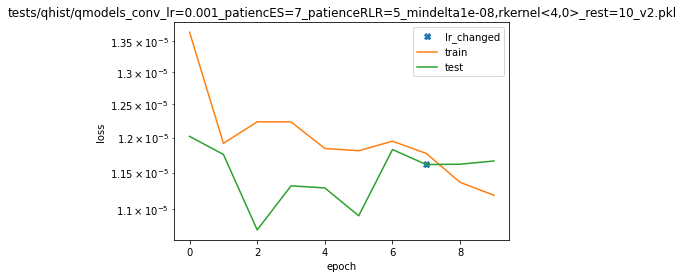

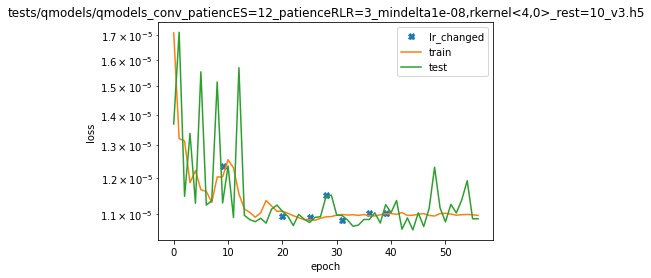

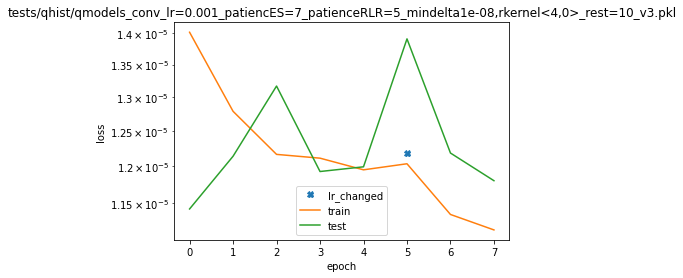

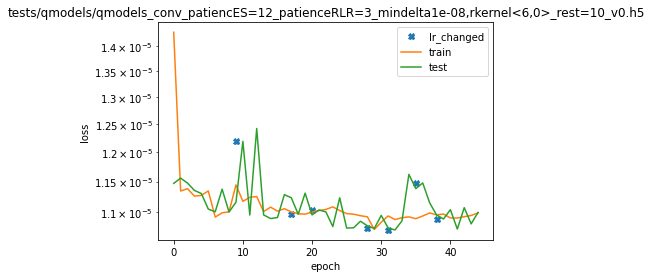

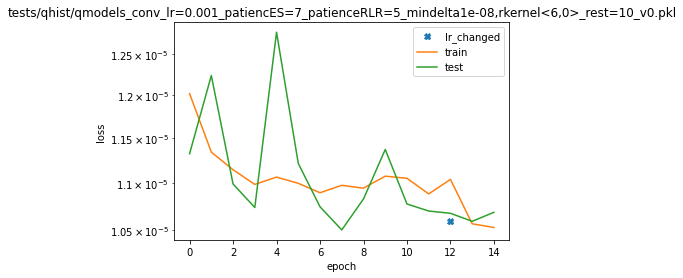

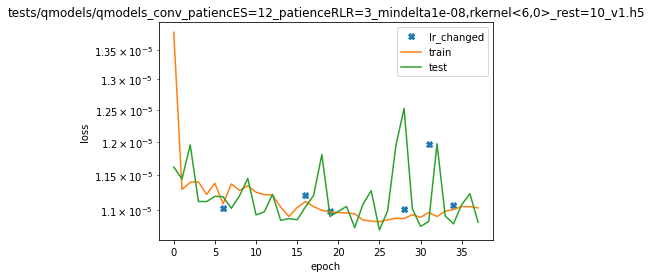

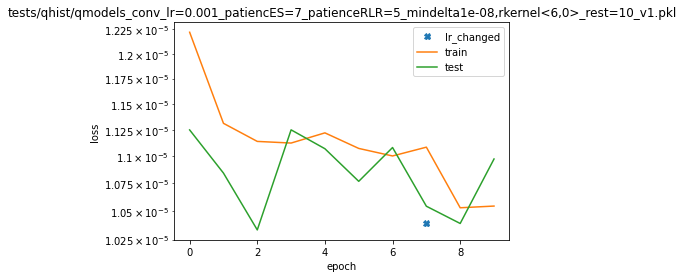

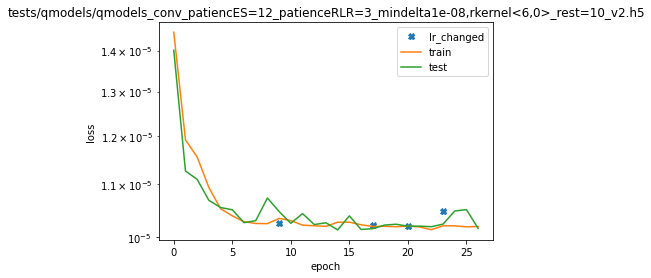

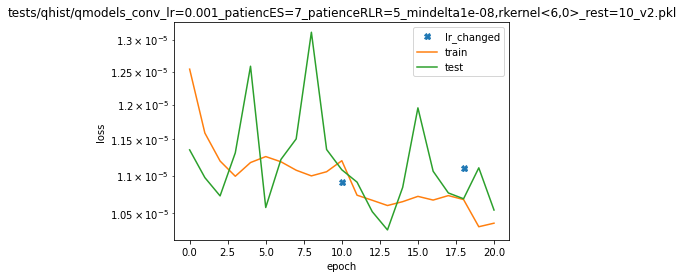

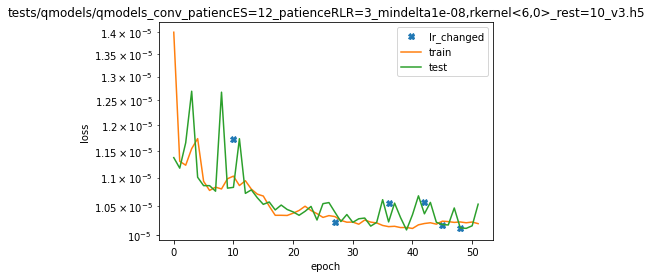

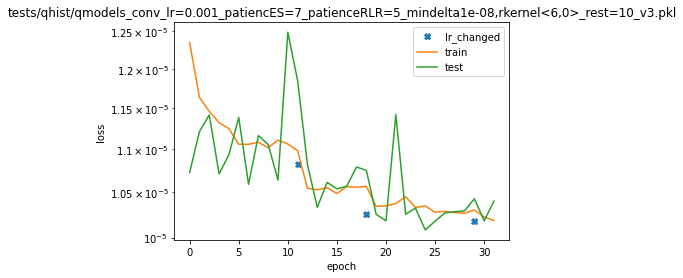

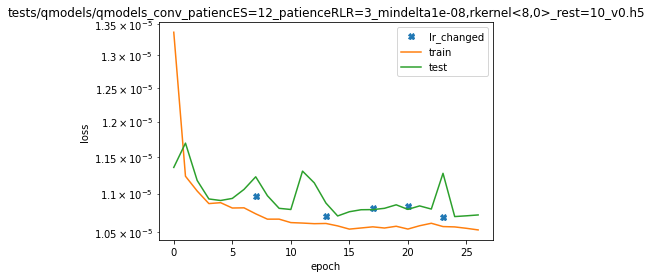

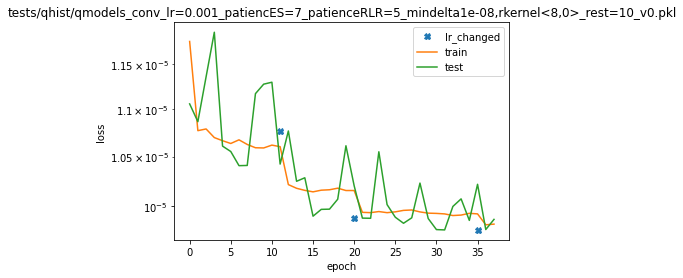

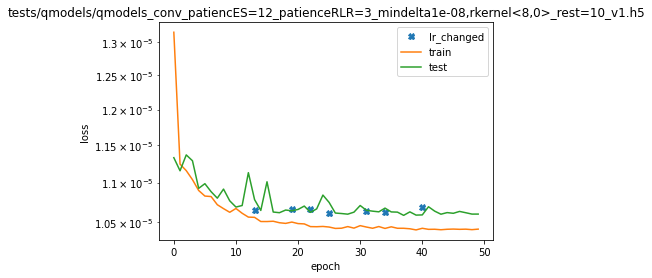

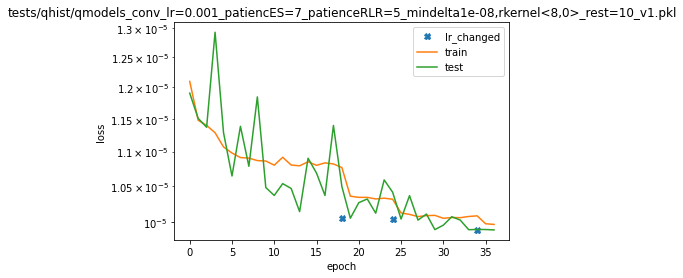

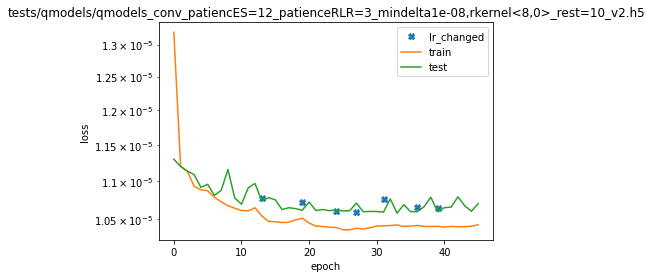

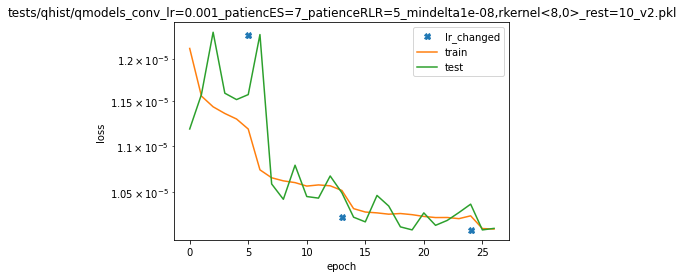

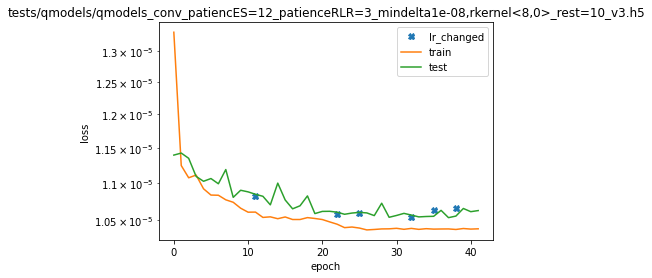

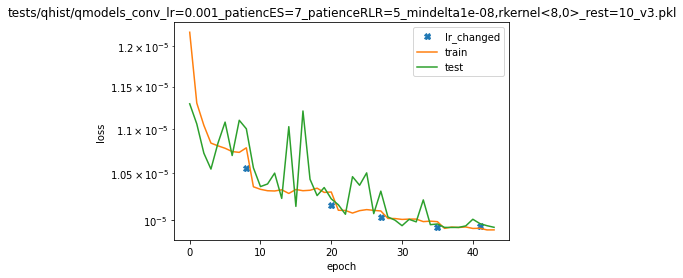

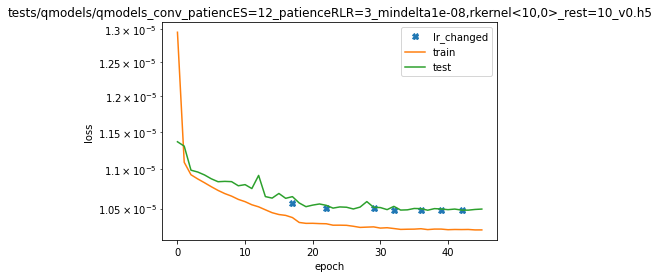

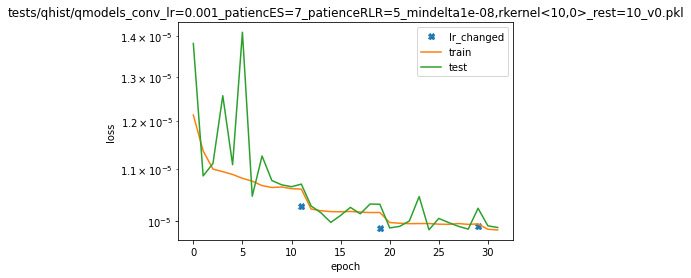

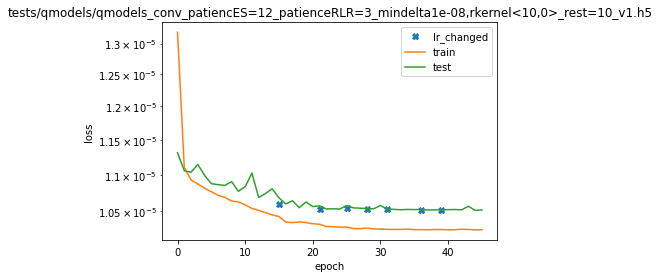

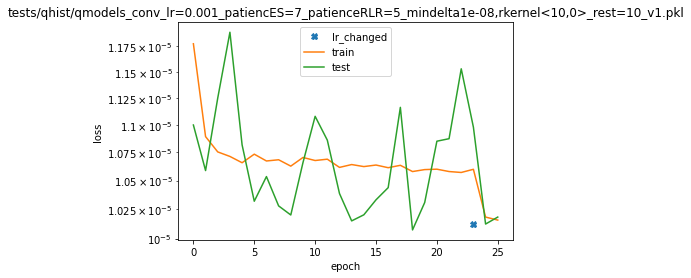

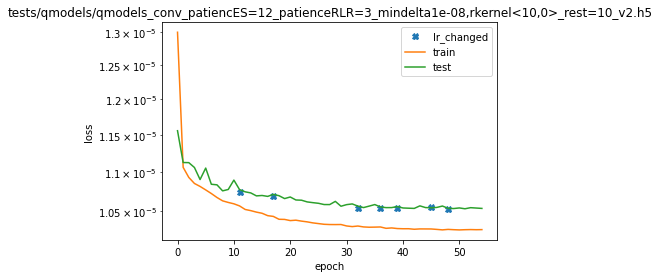

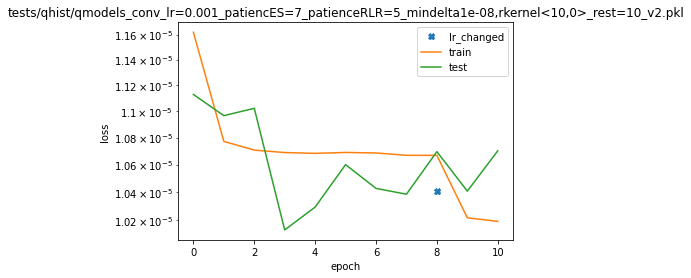

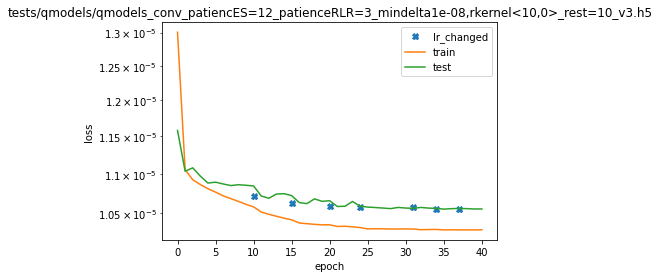

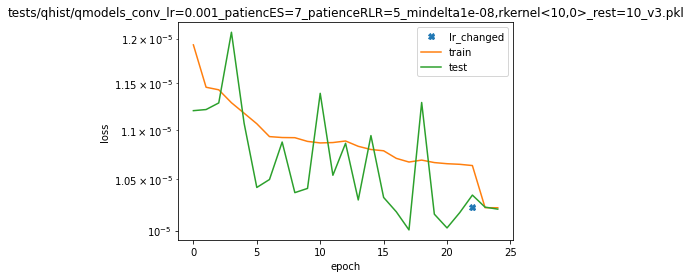

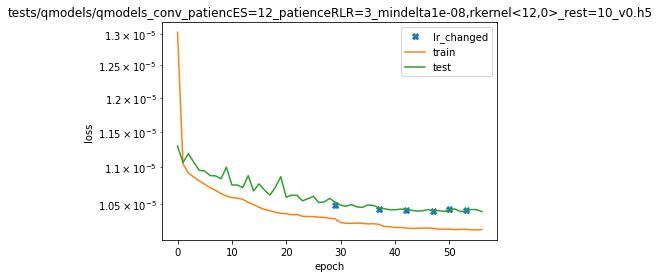

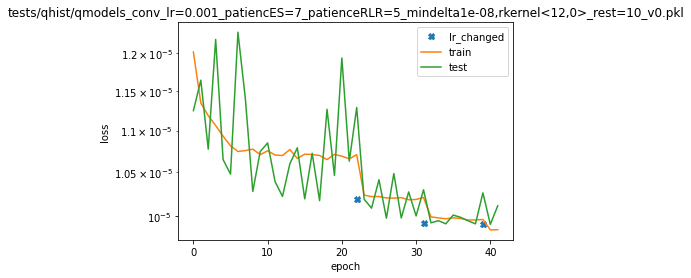

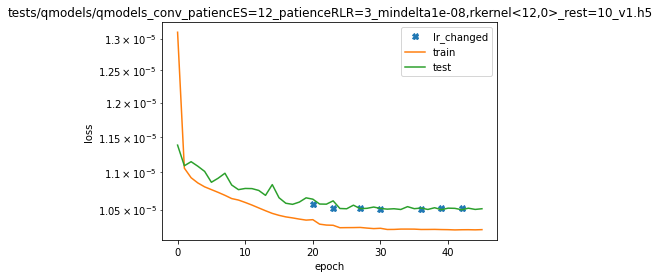

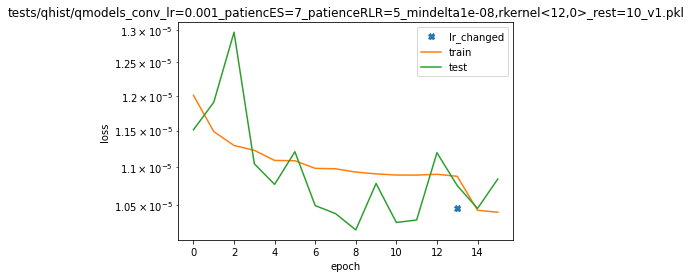

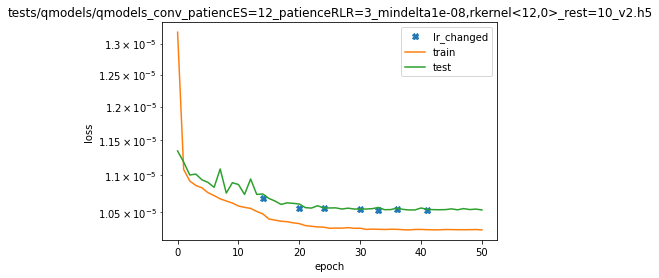

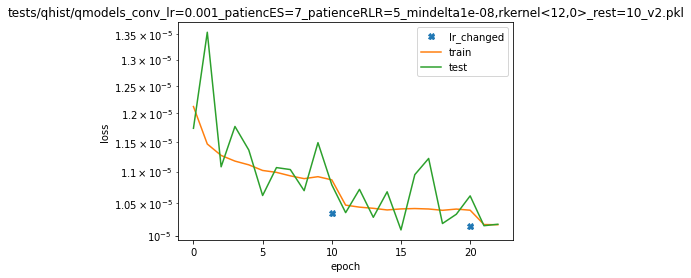

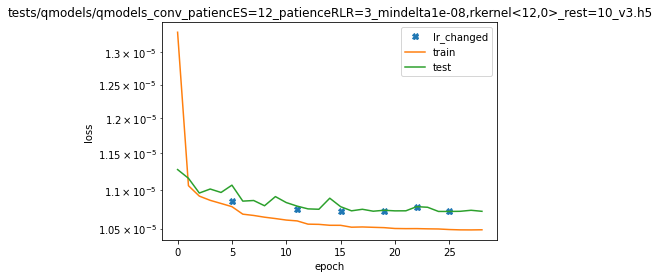

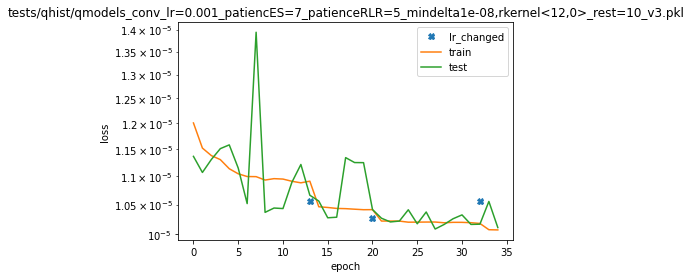

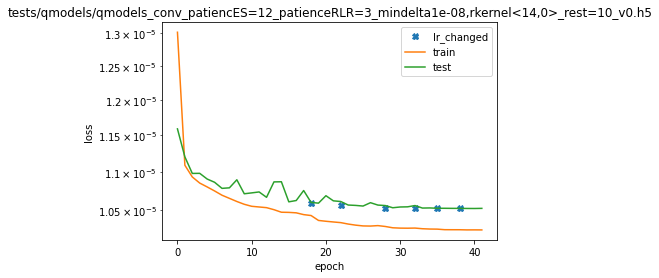

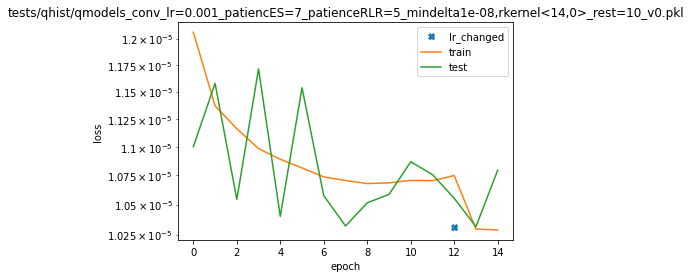

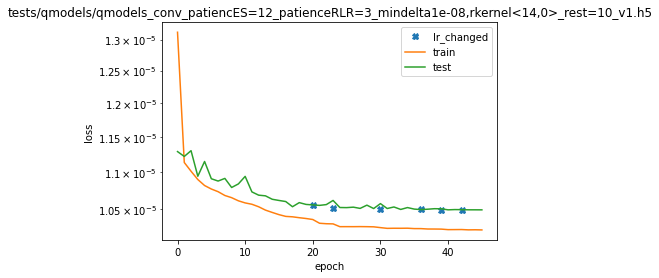

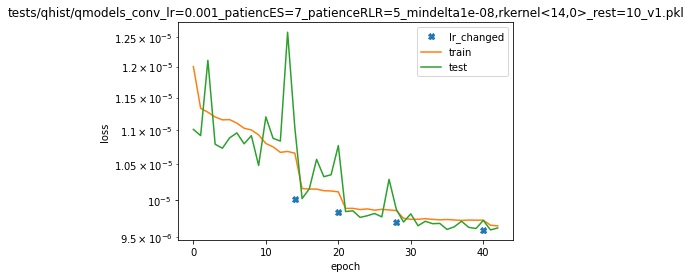

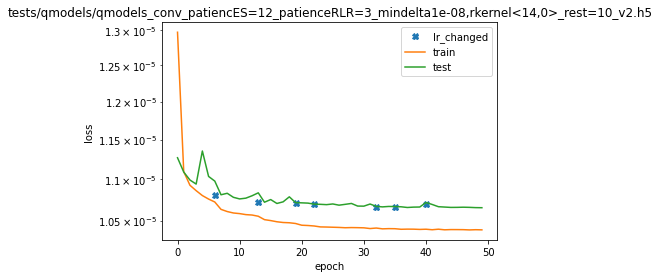

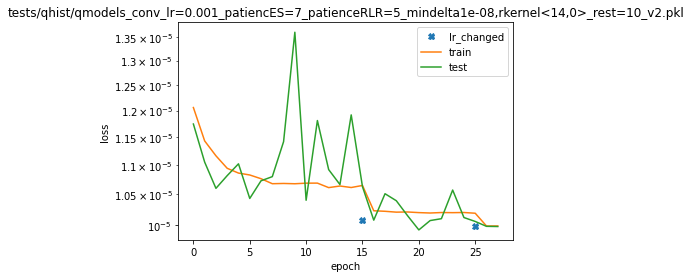

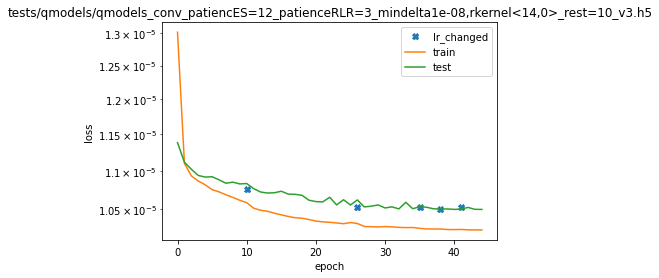

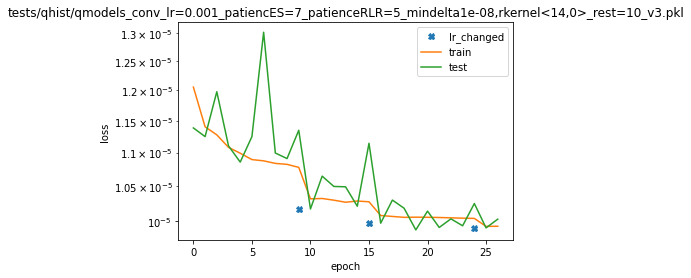

In [16]:
k=1
for i in range (bits_range):
    for v in range (versions_range):
    
        
        file_to_read = open(qhist_path(i,v,k),"rb")
        hist = pickle.load(file_to_read)
        lr_change = []
        for a in range (len(hist['lr'])-1):
        
            if (hist['lr'][a]==hist['lr'][a+1]):
                lr_change.append(None)
            else: 
                lr_change.append(hist['val_loss'][a+1])
        plt.plot(lr_change, 'X')
        plt.plot(hist['loss'])
        plt.plot(hist['val_loss'])
        plt.title(qmodels_path0(i,v,k))
        plt.yscale('log')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['lr_changed','train', 'test'])
        plt.show()
        
        file_to_read = open(qhist_path2(i,v,k),"rb")
        hist = pickle.load(file_to_read)
        lr_change = []
        for a in range (len(hist['lr'])-1):
        
            if (hist['lr'][a]==hist['lr'][a+1]):
                lr_change.append(None)
            else: 
                lr_change.append(hist['val_loss'][a+1])
        plt.plot(lr_change, 'X')
        plt.plot(hist['loss'])
        plt.plot(hist['val_loss'])
        plt.title(qhist_path2(i,v,k))
        plt.yscale('log')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['lr_changed','train', 'test'])
        plt.show()